In [1]:
# load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
%matplotlib inline


# load required functionality from keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers import Add, Subtract
from keras.callbacks import ModelCheckpoint, EarlyStopping, History 
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as keras_backend


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
keras_backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6699634675415405366
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15215496998979935122
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

    track_id       image_path       lp  train
0  s01_l01_1  s01_l01/1_1.png  7C24698      1
1  s01_l01_2  s01_l01/2_1.png  7C24698      1
2  s01_l01_2  s01_l01/2_2.png  7C24698      1
3  s01_l01_2  s01_l01/2_3.png  7C24698      1
4  s01_l01_2  s01_l01/2_4.png  7C24698      1
182336
1200
2400
3600
4800
6000
7200
8400
9600
10800
12000
13200
14400
15600
16800
18000
19200
20400
21600
22800
24000
25200
26400
27600
28800
30000
31200
32400
33600
34800
36000
37200
38400
39600
40800
42000
43200
44400
45600
46800
48000
49200
50400
51600
52800
54000
55200
56400
57600
58800
60000
61200
62400
63600
64800
66000
67200
68400
69600
70800
72000
73200
74400
75600
76800
78000
79200
80400
81600
82800
84000
85200
86400
87600
88800
90000
91200
92400
93600
94800
96000
97200
98400
99600
100800
102000
103200
104400
105600
106800
108000
109200
110400
111600
112800
114000
115200
116400
117600
118800
120000
121200
122400
123600
124800
126000
127200
128400
129600
130800
132000
133200
134400
135600
136800
138000
139

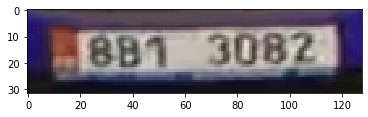

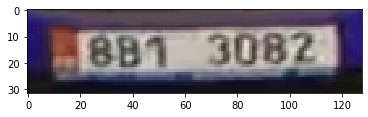

'\nfor i in range(800):\n    #str(i).zfill(4)\n    #format(i, \'04d\')\n    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, \'04d\') + ".png")\n    print(img.shape)\n    #plt.imshow(img)\n    #plt.show()\n\nimg = cv2.imread("../../DIV2K_train_HR/0002.png")\nimg2 = img[0:1024, 0:1024,:]\nimg2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb\nplt.imshow(img2)\nplt.show()\n'

In [2]:
"""
    Reading Data from files
"""
import gc

data = pd.read_csv("../../image/trainVal.csv")
#print(data)
print(data.head())
#inputX = data[["Unnamed: 0", "w1 = 4"]].to_numpy() #需要為 np.array 的形式!

print(len(data))#182336

#train valid test
#total 105924
dataX = np.zeros((20000, 16, 64, 3), dtype=int)
dataY = np.zeros((20000, 32, 128, 3), dtype=int)
count = 0


# not load test yet, due to not enough memory
# total 76412
finalTestX = np.zeros((20000, 32, 128, 3), dtype=int)
finalTestY = np.zeros((20000, 32, 128, 3), dtype=int)
testCount = 0


#cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]]) → dst
i = 0
for j in range(len(data)):
    #img = cv2.imread("../../image/s01_l01/1_1.png")
    if data["train"][i] == 0:
        img = cv2.imread("../../image/" + data["image_path"][i])
        #print(img.shape)
        img = cv2.resize(img, (128, 32))
        finalTestY[testCount] = img
        #img = cv2.resize(img, (64, 16))
        img = cv2.resize(img, (128, 32))
        finalTestX[testCount] = img
        testCount += 1
    i+=3 
    if i % 1200 == 0:
        print(i)
        #gc.collect()
    if testCount == 20000:
        break;
    
print(testCount)
#print(testCount)
print(finalTestY.shape)
#print(dataY[8])
plt.imshow(finalTestX[5])
plt.show()
plt.imshow(finalTestY[5])
plt.show()
    
    

"""
for i in range(800):
    #str(i).zfill(4)
    #format(i, '04d')
    img = cv2.imread("../../DIV2K_train_HR/"+ format(i+1, '04d') + ".png")
    print(img.shape)
    #plt.imshow(img)
    #plt.show()

img = cv2.imread("../../DIV2K_train_HR/0002.png")
img2 = img[0:1024, 0:1024,:]
img2 = img2[...,::-1] #bgr to rgb, inverse last 3 bgr to rgb
plt.imshow(img2)
plt.show()
"""


In [3]:
"""
Peak Signal-to-Noise Ratio:
     > 40dB: great
    30~40dB: good
    20~30dB: bad
     < 20dB: worse
def psnr(tf_img1, tf_img2):
    return tf.image.psnr(tf_img1, tf_img2, max_val=255)
"""
def PSNR(y_true, y_pred):
    return -10. * np.log10(np.mean(np.square(y_pred - y_true)))

def printHistory(history): 
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

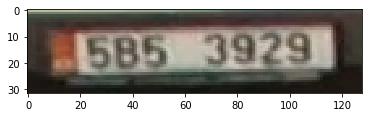

(20000, 32, 128, 3)


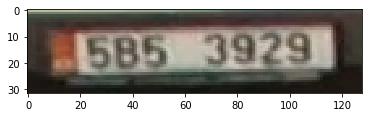

'\n# convert the class labels to 10-dimensional class arrays:\n# - before: y_train = (n_samples, )\n# - after: Y_train = (n_samples, 10)\n#\nY_train = np_utils.to_categorical(y_train, 10)\nY_test = np_utils.to_categorical(y_test, 10)\n'

In [4]:


"""
# reshape the data based on what backend is in use (TensorFlow or Thean)
if keras_backend.image_data_format() == 'channels_first': #Thean
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_test = X_test.reshape(-1, 1, 28, 28)
else: # TensorFlow
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1) #(batch, height, width, channels)
"""

img = finalTestY[1, :, :, :]
plt.imshow(img)
plt.show()

print(finalTestX.shape)

img = finalTestX[1, :, :, :]
plt.imshow(img)
plt.show()

# convert data type and normalize the values (8-bit = 256 = 0...255)
finalTestX = finalTestX.astype('float32') / 255
finalTestY = finalTestY.astype('float32') / 255

"""
# convert the class labels to 10-dimensional class arrays:
# - before: y_train = (n_samples, )
# - after: Y_train = (n_samples, 10)
#
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
"""


In [4]:
# create the CNN model
def CNN(pretrained_weights = None, input_size = (32,128,3)):
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size,
                     padding="same"
                    ))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    
model = CNN()
model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 128)      3584      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 128, 128)      147584    
_________________________________________________________________
conv

== CNN accuracy ==
Train loss: 0.00043873249872454576
Train accuracy: 0.9169571707589286
Test loss: 0.00044444283532599606
Test accuracy: 0.9175708821614583


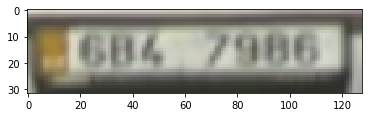

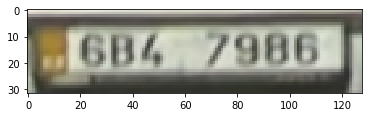

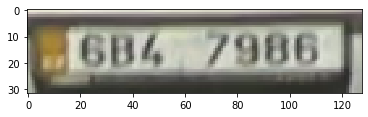

In [5]:
print("== CNN accuracy ==")
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()

In [6]:
# create the CNN model
def CNNnorm(pretrained_weights = None, input_size = (32,128,3)):
    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_size,
                     padding="same"
                    ))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    #model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model.add(BatchNormalization())

    model.add(Conv2D(3, (3, 3), activation='relu', padding="same"))

    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    
model = CNN()
model.fit(X_train, y_train,
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_data=(X_test, y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 128, 128)      3584      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 128, 128)      147584    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 128, 128)      147584    
__________

== CNNnorm accuracy ==
Train loss: 0.0005586981324345938
Train accuracy: 0.8747546037946429
Test loss: 0.0005632165572606027
Test accuracy: 0.8744114990234375


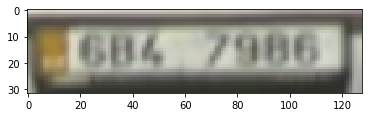

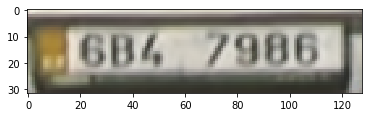

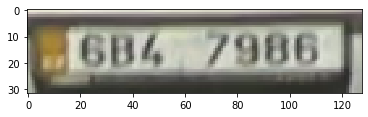

In [7]:
print("== CNNnorm accuracy ==")
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

result = model.predict(X_train)
img = X_train[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = y_train[1]
plt.imshow(img)
plt.show()

In [5]:
# U-net

def UNet(pretrained_weights = None, input_size = (32,128,3)):
    inputs = Input(input_size)

    # N*32*128*64
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(inputs)
    #conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(maxPool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv2)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(maxPool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(maxPool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(maxPool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(conv5)
    
    # N*4*16*512
    upConv1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv6)
    
    # N*8*32*256
    upConv2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv7)
    
    # N*16*64*128
    upConv3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv8)

    # N*32*128*64
    upConv4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv9)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
    

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 128, 64)  36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

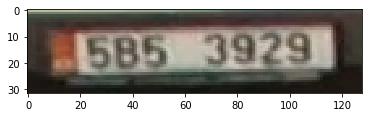

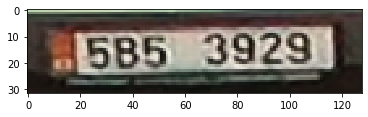

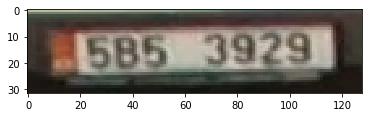

21.512889862060547
23.552613258361816


In [6]:
model = UNet("UNetWeights00000066.h5")
print("== UNet accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [7]:
def UNetNorm(pretrained_weights = None, input_size = (32,128,3)):
    inputs = Input(input_size)

    #https://www.zhihu.com/question/283715823
    #BN after relu
    
    # N*32*128*64
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(maxPool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(maxPool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(maxPool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(maxPool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding="same")(conv5)
    conv5 = BatchNormalization()(conv5)
    
    # N*4*16*512
    upConv1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding="same")(conv6)
    conv6 = BatchNormalization()(conv6)
    
    # N*8*32*256
    upConv2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding="same")(conv7)
    conv7 = BatchNormalization()(conv7)
    
    # N*16*64*128
    upConv3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding="same")(conv8)
    conv8 = BatchNormalization()(conv8)

    # N*32*128*64
    upConv4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding="same")(conv9)
    conv9 = BatchNormalization()(conv9)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 128, 64)  1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 128, 64)  256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 128, 64)  36928       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

== UNetNormAfter accuracy ==
Valid loss: 0.004964827325847
Valid accuracy: 0.8299493408203125


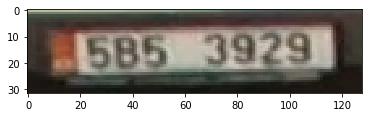

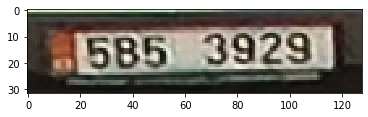

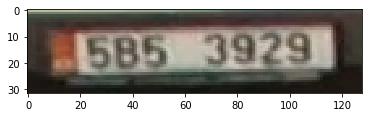

20.784854888916016
23.04096221923828


In [8]:
model = UNetNorm("UNetNorm00000099.h5")
print("== UNetNormAfter accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [9]:

def UNetNormBefore(pretrained_weights = None, input_size = (32,128,3)):
    inputs = Input(input_size)

    #https://www.zhihu.com/question/283715823
    #BN after relu
    
    # N*32*128*64
    conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    
    # N*16*64*128
    maxPool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), padding="same")(maxPool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    
    # N*8*32*256
    maxPool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), padding="same")(maxPool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    
    # N*4*16*512
    maxPool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, (3, 3), padding="same")(maxPool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation("relu")(conv4)
    
    # N*2*8*1024
    maxPool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, (3, 3), padding="same")(maxPool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)
    conv5 = Conv2D(1024, (3, 3), padding="same")(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation("relu")(conv5)
    
    # N*4*16*512
    upConv1 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(512, (3, 3), padding="same")(concatenate([conv4,upConv1], axis=3))
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, (3, 3), padding="same")(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation("relu")(conv6)
    
    # N*8*32*256
    upConv2 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, (3, 3), padding="same")(concatenate([conv3,upConv2], axis=3))
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, (3, 3), padding="same")(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation("relu")(conv7)
    
    # N*16*64*128
    upConv3 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, (3, 3), padding="same")(concatenate([conv2,upConv3], axis=3))
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, (3, 3), padding="same")(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation("relu")(conv8)

    # N*32*128*64
    upConv4 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, (3, 3), padding="same")(concatenate([conv1,upConv4], axis=3))
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, (3, 3), padding="same")(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation("relu")(conv9)
    
    # N*32*128*3
    result = Conv2D(3, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model


C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:91: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 128, 64)  1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 128, 64)  256         conv2d_39[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 128, 64)  0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_40 

== UNetNormBefore accuracy ==
Valid loss: 0.004588336703367531
Valid accuracy: 0.8809886962890625


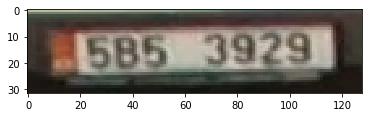

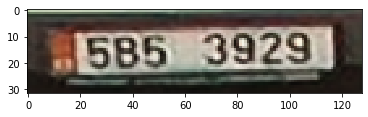

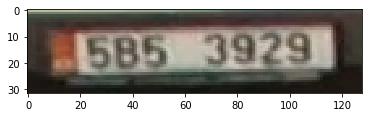

21.96038246154785
23.383448123931885


In [10]:
model = UNetNormBefore("UNetNormBeforeWeights00000077.h5")
print("== UNetNormBefore accuracy ==")
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [11]:
# Residual Network
from keras.layers import Lambda
import tensorflow as tf

def SubpixelConv2D(scale, **kwargs):
    return Lambda(lambda x: tf.depth_to_space(x, scale), **kwargs)

def origin_residual_block(inputX, filters=64, kernel_size=(3,3), increase=False):
    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
        
    #first
    x = Conv2D(filters, kernel_size, padding="same")(inputX)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    #second 
    x = Conv2D(filters, kernel_size, padding="same")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    
    if increase:
        inputX = Conv2D(filters * 4, kernel_size=(1,1), strides=stride, padding='same')(inputX)
        inputX = BatchNormalization(axis=bn_axis)(inputX)

    #shortcut
    x = Add()([x, inputX])
    x = Activation("relu")(x)
    return x

def residual_block(inputX, kernel_size, increase=False):
    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
        
    #first
    x = Conv2D(192, kernel_size, padding="same")(inputX)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    #second 
    x = Conv2D(64, kernel_size, padding="same")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)
    
    
    if increase:
        inputX = Conv2D(64 * 4, kernel_size=(1,1), strides=stride, padding='same')(inputX)
        inputX = BatchNormalization(axis=bn_axis)(inputX)

    #shortcut
    x = Add()([x, inputX])
    return x


def ResNet(pretrained_weights = None, scale=2, num_res_blocks=16, input_size=(32,128,3)):
    inputs = Input(input_size)

    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    
    #start
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    #x = BatchNormalization(axis=bn_axis)(x)
    #x = Activation('relu')(x)
    #x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #residual
    for i in range(num_res_blocks):
        #x = residual_block(x, 3)
        x = origin_residual_block(x)
    x = Conv2D(3 * scale**2, (3,3), padding='same')(x)
    x = SubpixelConv2D(scale)(x) # N*32*128*3

    #shortcut
    s = Conv2D(3 * scale**2, (3,3), strides=(2, 2), padding='same')(inputs)
    s = SubpixelConv2D(scale)(s) # N*32*128*3
    
    result = Add()([x, s])
    
    model = Model(input = inputs, output = result)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
"""
keras_backend.clear_session() #release GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()
"""


'\nkeras_backend.clear_session() #release GPU memory\nfrom numba import cuda\ncuda.select_device(0)\ncuda.close()\n'

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:86: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ad...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 16, 64, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 16, 64, 64)   36928       conv2d_58[0][0]                  
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 16, 64, 64)   256         conv2d_59[0][0]                  
__________________________________________________________________________________________________
activation

== ResNet accuracy ==
Valid loss: 0.003511997463181615
Valid accuracy: 0.727678662109375


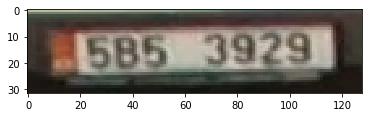

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


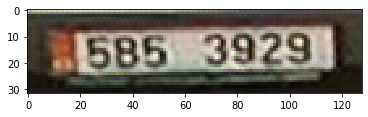

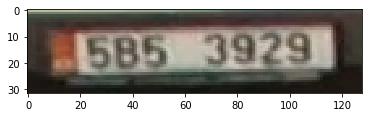

24.089794158935547
24.544453620910645


In [12]:
model = ResNet("ResNetWeights00000091.h5")
print("== ResNet accuracy ==") #Residual
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )

In [13]:
# Residual Network
# Residual Network
from keras.layers import Lambda
import tensorflow as tf
from keras.layers import Conv2DTranspose

def SubpixelConv2D(scale, **kwargs):
    return Lambda(lambda x: tf.depth_to_space(x, scale), **kwargs)

def residual_block(inputX, kernel_size, increase=False):
    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
        
    #first
    x = Conv2D(192, kernel_size, padding="same")(inputX)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    #second 
    x = Conv2D(64, kernel_size, padding="same")(x)
    x = BatchNormalization(axis=bn_axis)(x)
    #x = Activation("relu")(x)
    
    
    if increase:
        inputX = Conv2D(64 * 4, kernel_size=(1,1), strides=stride, padding='same')(inputX)
        inputX = BatchNormalization(axis=bn_axis)(inputX)

    #shortcut
    x = Add()([x, inputX])
    x = Activation("relu")(x)
    return x


def ResNet(pretrained_weights = None, scale=2, num_res_blocks=16, input_size=(32,128,3)):
    inputs = Input(input_size)

    if keras_backend.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    
    #start
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    #x = BatchNormalization(axis=bn_axis)(x)
    #x = Activation('relu')(x)
    #x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #residual
    for i in range(num_res_blocks):
        x = residual_block(x, 3)
        #x = origin_residual_block(x)
    x = Conv2D(3 * scale**2, (3,3), padding='same')(x)
    x = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding="same")(x)

    
    #shortcut
    s = Conv2D(3 * scale**2, (3,3), strides=(2, 2), padding='same')(inputs)
    s = Conv2DTranspose(3, (3, 3), strides=(2, 2), padding="same")(s) # N*32*128*3
    
    result = Add()([x, s])
    

#    model = Model(input = inputs, output = result)
    model = Model(input = inputs, output = x)
    
    print(model.summary())

    model.compile(loss='mean_squared_error',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model
"""
keras_backend.clear_session() #release GPU memory
from numba import cuda
cuda.select_device(0)
cuda.close()
"""

'\nkeras_backend.clear_session() #release GPU memory\nfrom numba import cuda\ncuda.select_device(0)\ncuda.close()\n'

C:\Users\asus\Miniconda3\envs\testJ\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 128, 3)   0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 16, 64, 64)   1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 16, 64, 192)  110784      conv2d_93[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 16, 64, 192)  768         conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation

== ResNet accuracy ==
Valid loss: 0.002850822141766548
Valid accuracy: 0.8017879272460937


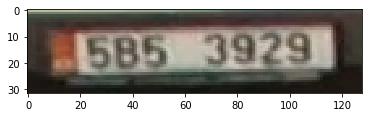

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


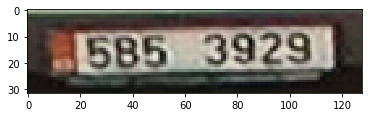

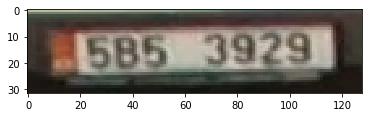

24.376256465911865
25.450291633605957


In [14]:
model = ResNet("wdsr00000095.h5")
print("== ResNet accuracy ==") #Residual
score = model.evaluate(finalTestX, finalTestY, verbose=0)
print('Valid loss:', score[0])
print('Valid accuracy:', score[1])

result = model.predict(finalTestX)
img = finalTestX[1]
plt.imshow(img)
plt.show()
# show the image
img = result[1]
plt.imshow(img)
plt.show()
img = finalTestY[1]
plt.imshow(img)
plt.show()

print( PSNR(result[1], finalTestY[1]) )
print( PSNR(result, finalTestY) )